# DProvDB Experimental Evaluation

We would like to understand DProvDB's performance via empirical study.

## End-to-end Comparison

First we would like to perform an end-to-end comparison of DProvDB against baseline systems.

We have the following baselines:

- DProvDB minus additiveGM (Vanilla mechanism in our paper)
- Chorus
- DProvDB minus cached views (i.e., enabling Chorus with Provenance table)
- Simulating PrivateSQL 

Note that the key idea in PrivateSQL is to generate synopses for pre-determined views and answer queries using synopses.
The overall privacy budget is split to generate the synopses in advance.
One prominent way to allocate budget to views, as mentioned in PrivateSQL paper, is fair allocation.
That is to split the budget w.r.t the sensitivity of the views s.t. the expected error on each view is the same.
Since PrivateSQL system is not open source, we use our system with a specific setting to simulate PrivateSQL.

Each experiment is run for 4 times, we plot the mean and the variance as evaluation results.

In [3]:
# load package and fonts

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(font="Helvetica", rc={"figure.figsize":(4, 3)})
sns.set_theme(style="white")
sns.set_style('ticks')
sns.set_context("paper", font_scale=1.3, rc={"lines.linewidth": 1.75})

1) RRQ, over Adult dataset

In [4]:
# load data

report = pd.read_csv('../data/RRQ_adult_end_to_end_delta.csv', sep=';')

report = report.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
report.columns = report.columns.str.strip()


# processing list strings

def parse_list(s):
    if isinstance(s, str) and s.startswith('List') and s[5: -1] != "":
        return [float(x) for x in s[5: -1].split(",")]
    else:
        return s

report = report.applymap(parse_list)

report.loc[(report["viewConstraintFlag"] == "static fixed-normalized: 1.0") & (report["mechanism"] == "baseline"), "mechanism"] = "PrivateSQL"
report.loc[(report["viewConstraintFlag"] == "static fixed-normalized: 1.0") & (report["mechanism"] == "PrivateSQL"), "viewConstraintFlag"] = "dynamic fixed-normalized: 1.0"

report.head(5)

,dataset,mechanism,task,viewConstraintFlag,budget,utility,totalNoOfQueries,analystConstraints,setup_time,execution_time,utility_breakdown,DCFG,accountant,accountant_breakdown,view_breakdown,avgAccuracy,runIndex,perQueryDelta,randomness
0,adult,aGM,RRQ_round-robin,dynamic fixed-aGM: 1.0,6.4,5381,8000,"[0.7111111111111111, 6.4]",9999.021983,11028.814939,"[2467.0, 2914.0]",21637.653801,6.473434,"[0.7146219889322916, 6.473433780670167]","[1.0191582679748534, 0.0, 1.1891436576843262, ...",1595.8598773462181,1,1.000000e-09,1025
1,adult,baseline,RRQ_round-robin,dynamic fixed-normalized: 1.0,6.4,3825,8000,"[0.64, 5.76]",9999.021983,4980.404969,"[1149.0, 2676.0]",18753.896902,6.221392,"[0.6305460357666015, 5.59084608078003]","[1.140208339691162, 0.0, 1.2151661491394041, 0...",1798.6091503267974,1,1.000000e-09,1025
2,adult,PrivateSQL,RRQ_round-robin,dynamic fixed-normalized: 1.0,6.4,20,8000,"[0.64, 5.76]",9999.021983,3159.484697,"[10.0, 10.0]",75.788105,0.000000,"[0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2763.8,1,1.000000e-09,1025
3,adult,Chorus,RRQ_round-robin,static fixed-normalized: 1.0,6.4,11,8000,"[0.64, 5.76]",9999.021983,5440.017060,"[6.0, 5.0]",38.894053,6.384030,"[3.436964225769043, 2.947065925598145]","[0.0, 0.0, 3.6182746887207036, 0.0, 0.0, 0.0, ...",2994.7272727272725,1,1.000000e-09,1025
4,adult,ChorusP,RRQ_round-robin,static fixed-normalized: 1.0,6.4,10,8000,"[0.64, 5.76]",9999.021983,3879.620997,"[1.0, 9.0]",60.209295,5.998610,"[0.3858149719238281, 5.6127950477600095]","[0.0, 0.0, 3.3346665477752686, 0.0, 0.0, 0.0, ...",2996.4,1,1.000000e-09,1025


In [5]:
# processing data

mechanism_mapping = {"aGM": "DProvDB", "baseline": "Vanilla", "Chorus": "Chorus", "ChorusP": "ChorusP", "PrivateSQL": "sPrivateSQL"}

epsilon_mapping = {0.4: "$\epsilon=0.4$", 0.8: "$\epsilon=0.8$", 1.6: "$\epsilon=1.6$", 3.2: "$\epsilon=3.2$", 6.4: "$\epsilon=6.4$"}

delta_mapping = {1.000000e-09: "1e-9", 1.000000e-10: "1e-10", 1.000000e-11: "1e-11", 1.000000e-12: "1e-12", 1.000000e-13: "1e-13"}

def processing_data_delta(df, dataset, task, metric, workload_size, constraint_setting = "dynamic fixed: 1.0", mech_dt = ["aGM", "baseline"]):
    
    filtered_df = df[(df["dataset"]==dataset) & (df["task"]==task)]
            
    ret_dt = {}

    for mech in mech_dt:
                
        for delta in sorted(set(filtered_df['perQueryDelta'])):
            
            filtered_df_eps = filtered_df[filtered_df['perQueryDelta']==delta]
            
            if metric == "utility" or metric == "DCFG":
                ret_dt[(mechanism_mapping[mech], delta_mapping[delta])] = list(filtered_df_eps[filtered_df_eps['mechanism']==mech][metric].values)
            
    
    return ret_dt


# test
# processing_data(pd.concat([report.iloc[:960], report.iloc[2881:]]), "adult", "RRQ_round-robin", "utility", 8000)


/u5/s693zhan/.conda/envs/DProvDB_build/lib/python3.8/site-packages/seaborn/utils.py:470: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/u5/s693zhan/.conda/envs/DProvDB_build/lib/python3.8/site-packages/seaborn/utils.py:470: UserWarning: The label '_container0' of <BarContainer object of 5 artists> starts with '_'. It is thus excluded from the legend.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/u5/s693zhan/.conda/envs/DProvDB_build/lib/python3.8/site-packages/seaborn/utils.py:470: UserWarning: The label '_container1' of <BarContainer object of 5 artists> starts with '_'. It is thus excluded from the legend.
  new_legend = legend_func(handles, labels, loc=loc, **props)


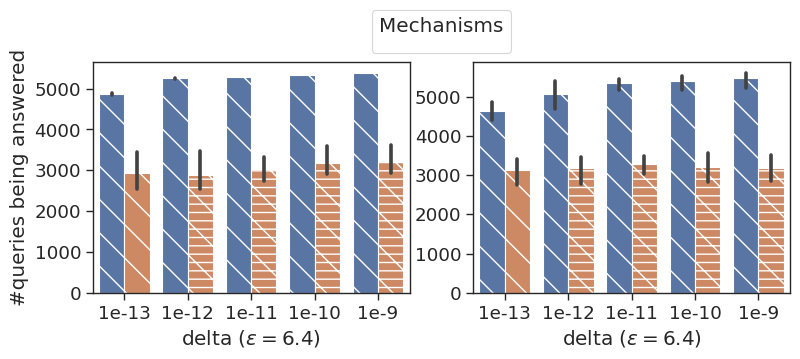

In [ ]:
# plotting

report_aGM = report

# get data
adult_a_utility = processing_data_delta(report_aGM, "adult", "RRQ_round-robin", "utility", 20000)
adult_aa_utility = processing_data_delta(report_aGM, "adult", "RRQ_random", "utility", 20000)

hatches = ['\\', '-\-']

sns.set(font="Helvetica", rc={"figure.figsize":(4, 3)})
sns.set_theme(style="white")
sns.set_style('ticks')
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.75})

# drawing figures
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))

data = pd.Series(adult_a_utility).reset_index()
data.columns = ['mechanisms', 'analysts', 'utility']
data = data.explode("utility")
bar = sns.barplot(data=data, x='analysts', y='utility', hue='mechanisms', ax=axes[0], )
axes[0].set(ylabel="#queries being answered")
axes[0].set(xlabel="delta ($\epsilon=6.4$)")
patches = [patch for patch in bar.patches]
h = [hatches[i//(len(patches) // len(hatches))] for i in range(len(patches))]
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)

# get container objects for each hue category
containers = bar.containers

# create legend handles
handles = []
for container in containers:
    for rect in container:
        handles.append(rect)
sns.move_legend(axes[0], "lower center", bbox_to_anchor=(1.1, 1), ncol=4, title="Mechanisms", frameon=True, handles=containers, )



data = pd.Series(adult_aa_utility).reset_index()
data.columns = ['mechanisms', 'eps', 'utility']
data = data.explode("utility")
bar = sns.barplot(data=data, x='eps', y='utility', hue='mechanisms', ax=axes[1], )
axes[1].set(ylabel="#queries being answered")
axes[1].set(xlabel="delta ($\epsilon=6.4$)")
axes[1].set(ylabel=None)
axes[1].legend_.remove()
patches = [patch for patch in bar.patches]
h = [hatches[i//(len(patches) // len(hatches))] for i in range(len(patches))]
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)




plt.savefig('delta.pdf', dpi=600, bbox_inches='tight')

